Program Name: Jet_Length_Width_Determiner_v5.py

Date: 6/11/2022

Creator: Sol Samuels

Description: 
 - This program intakes jet related FITS files from ones device, specifically those named in the format \*\*/Group\*0.00_1.00_0.00\*.fits\* , and returns the jet's estimated length and width.
 - The program also displays normalized cumulative histogram figures for jet intensits by row or column of fits image as pixel count increases from the edge of the jet.
 - NOTE: This is version 1 of this program. Program is subject to be changed.
 
Variable Keywords:
 - cul = "cumulative"
 - slice = refers to rows or columns of fits image pixels
 - vals = "values"
 - norm = "normalized"

In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema


In [2]:
def kpc_convert(pixel_len, pixel_size):
    cm_len = pixel_len * pixel_size
    kpc_len = round((cm_len * 3.24077928967e-19) / 1e3, 4)
    return kpc_len

In [3]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, width, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)

        if element == 1:
            final_reached = True
        
    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(np.median(x_vals))
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
    
    
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    d3 = np.gradient(smooth_d2)
    smooth_d3 = gaussian_filter1d(d3, 300)
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    
    # for local maxima
    maxima_d2 = argrelextrema(smooth_d2, np.greater)
    # for local minima
    minima_d2 = argrelextrema(smooth_d2, np.less)
    
    
    norm_smooth_d1 = smooth_d1 / np.max(smooth_d1)
    norm_smooth_d2 = smooth_d2 / np.max(smooth_d2)
    norm_smooth_d3 = smooth_d3 / np.max(smooth_d3)
    
    #edited normalized cumulative histogram of data
    plt.plot(x_vals, norm_cul_vals_edit, color='b', label = "raw")
    #plt.plot(norm_smooth_d1, label='1st derivative', color = "g")
    #plt.plot(norm_smooth_d2, label='2nd derivative', color = "orange")
    #plt.plot(norm_smooth_d3, label='3rd derivative', color = "r")
    labelcount = 0
    #for i, infl in enumerate(infls, 1):
        #if labelcount == 0:
            #plt.axvline(x=infl, color='k', linestyle='dashed', label="Inflection Points")
        #else:
            #plt.axvline(x=infl, color='k', linestyle='dashed')
        #labelcount += 1
        

    min_lst = []
    max_lst = []
    if len(maxima_d2) > 0:
        for element in maxima_d2:
            for index in element:
                try:
                    plt.axvline(x=index, color='r', linestyle='dashed')
                    max_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    if len(minima_d2) > 0:
        for element in minima_d2:
            for index in element:
                try:
                    plt.axvline(x=index, color='y', linestyle='dashed')
                    min_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
                    
    plt.legend()
    plt.title("Normalized Cumulative Histogram of Jet Intensities From Bottom to Top")
    plt.xlabel("Number of pixels from bottom edge of jet")
    plt.ylabel("Normalized Cumulative Value")
    plt.show()
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    print("\nLength of Jet in Pixels: {} pixels".format(pixel_count))

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    print("Jet Length in cm (y-direction): {} cm".format(jet_size_cm))
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    print("Jet Length in kpc (y-direction): {} kpc".format(jet_size_kpc))
    

    max_lst = sorted(max_lst)
    min_lst = sorted(min_lst)
    
    if (len(max_lst) + len(min_lst)) > 3:
        try:
            main_max = []
            main_min = []
            for point in max_lst:
                if point > x_vals_med and point < x_vals_Q3:
                    main_max.append(point)
            for point in min_lst:
                if point > x_vals_Q1 and point < x_vals_med:
                    main_min.append(point)
                    
            if len(main_max) == 0:
                for point in max_lst:
                    if point > x_vals_med:
                        main_max.append(point)
            if len(main_min) == 0:
                for point in min_lst:
                    if point < x_vals_med:
                        main_min.append(point)

            slice_vals_edit = []
            flag = False
            for element in slice_vals:
                if flag is True:
                    slice_vals_edit.append(element)
                if element != 0 and flag is False:
                    flag = True
                    slice_vals_edit.append(element)

            for i in range(max(main_min), min(main_max)):
                slice_vals_edit[i] = float(0)

            lobe_dist = min(main_max) - max(main_min)

            cul_vals = []
            movingsum = 0
            for element in slice_vals_edit:
                movingsum += element
                cul_vals.append(movingsum)

            #Normalizes the Cumulative Values and creates list
            max_val = cul_vals[-1]
            norm_cul_vals = []
            norm = 0
            for element in cul_vals:
                norm = element / max_val
                norm_cul_vals.append(norm)

            #Edits the Normalizes Values to Exclude zeros and repeating terms
            final_reached = False
            norm_cul_vals_edit = []
            for element in norm_cul_vals:
                if element != 0 and final_reached is False:
                    norm_cul_vals_edit.append(element)
                if element == 1:
                    final_reached = True

            x_vals = []
            for x in range(len(norm_cul_vals_edit)):
                d = kpc_convert(x, pixel_size)
                x_vals.append(d)

            plt.plot(x_vals, norm_cul_vals_edit, color='b')
            plt.title("Normalized Cumulative Histogram of Jet Intensities From Bottom to Top")
            plt.xlabel("Distance from bottom of jet (kpc)")
            plt.ylabel("Normalized Cumulative Value")
            plt.show()



            #Determines and prints length of jet in pixels. Estimates to 0.98
            pixel_count = 0
            for element in norm_cul_vals_edit:
                if element >= 0.02 and element <= 0.98:
                    pixel_count += 1
            print("\nLength of Jet in Pixels: {} pixels".format(pixel_count))

            #Converts pixel size to cm and prints
            jet_size_cm = pixel_size * pixel_count
            print("Jet Length in cm (y-direction): {} cm".format(jet_size_cm))

            #Converts cm size to kpc and prints
            jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
            print("Jet Length in kpc (y-direction): {} kpc".format(jet_size_kpc))

            lobe_dist_cm = lobe_dist * pixel_size
            lobe_dist_kpc = round((lobe_dist_cm * 3.24077928967e-19) / 1e3, 4)
            print("Distance between lobes (inner edge to edge): {} kpc".format(lobe_dist_kpc))
        except ValueError:
            p=0


            

In [4]:
#This Function Takes FITS data, FITS image width and pixel size to display Jet Width Info
def jet_width(data, width, pixel_size):
    
    #Reorients data so rows become columns
    data_reorient = []
    for x in range(width):
        col_sub = []
        for row in data:
            col_sub.append(row[x])
        data_reorient.append(col_sub)
        
    #Creates list of slice sums
    slice_vals = []
    for row in data_reorient:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True

    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
    
    
    #Creates normalized cumulative histogram of data
    plt.plot(x_vals, norm_cul_vals_edit, color='red')
    plt.title("Normalized Cumulative Histogram of Jet Intensities From Left to Right")
    plt.xlabel("Number of pixels from left edge of jet")
    plt.ylabel("Normalized Cumulative Value")
    plt.show()
    

    
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    print("\nWidth of Jet in Pixels: {} pixels".format(pixel_count))

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    print("Jet Width in cm (x-direction): {} cm".format(jet_size_cm))
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    print("Jet Width in kpc (x-direction): {} kpc".format(jet_size_kpc))
    


JET LENGTH AND WIDTH DETERMINING PROGRAM:
____________________________________________________________________________________________________

File Number 1/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_0010_nu=395.0_los=0.00_1.00_0.00_1.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 1.0 Myr - 395 MHz
Time index: 1.0003e+00 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 48x48 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



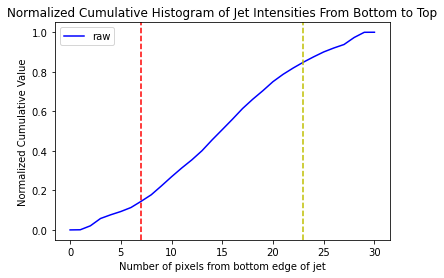


Length of Jet in Pixels: 27 pixels
Jet Length in cm (y-direction): 3.375e+22 cm
Jet Length in kpc (y-direction): 10.9376 kpc
____________________________________________________________________________________________________

File Number 2/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_0020_nu=395.0_los=0.00_1.00_0.00_2.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 2.0 Myr - 395 MHz
Time index: 2.0003e+00 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 80x80 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



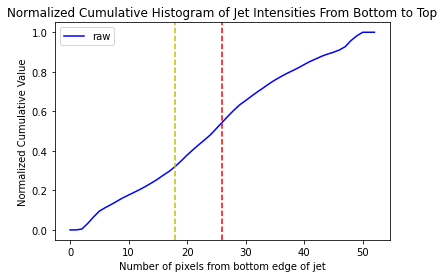


Length of Jet in Pixels: 46 pixels
Jet Length in cm (y-direction): 5.75e+22 cm
Jet Length in kpc (y-direction): 18.6345 kpc
____________________________________________________________________________________________________

File Number 3/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_0040_nu=395.0_los=0.00_1.00_0.00_4.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 4.0 Myr - 395 MHz
Time index: 4.0003e+00 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 144x144 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



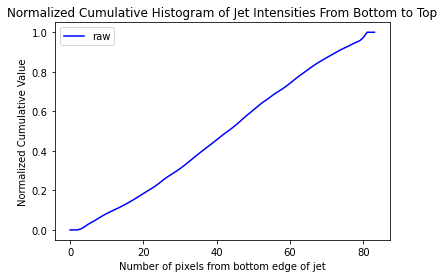


Length of Jet in Pixels: 76 pixels
Jet Length in cm (y-direction): 9.5e+22 cm
Jet Length in kpc (y-direction): 30.7874 kpc
____________________________________________________________________________________________________

File Number 4/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_0080_nu=395.0_los=0.00_1.00_0.00_8.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 8.0 Myr - 395 MHz
Time index: 8.0001e+00 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 272x272 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



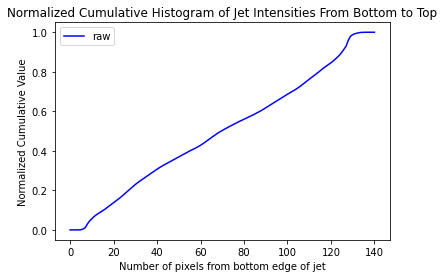


Length of Jet in Pixels: 122 pixels
Jet Length in cm (y-direction): 1.525e+23 cm
Jet Length in kpc (y-direction): 49.4219 kpc
____________________________________________________________________________________________________

File Number 5/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_0160_nu=395.0_los=0.00_1.00_0.00_16.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 16.0 Myr - 395 MHz
Time index: 1.6000e+01 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 464x464 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



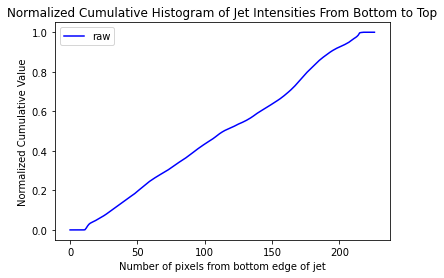


Length of Jet in Pixels: 201 pixels
Jet Length in cm (y-direction): 2.5125e+23 cm
Jet Length in kpc (y-direction): 81.4246 kpc
____________________________________________________________________________________________________

File Number 6/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_0320_nu=395.0_los=0.00_1.00_0.00_32.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 32.0 Myr - 395 MHz
Time index: 3.2000e+01 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 720x720 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



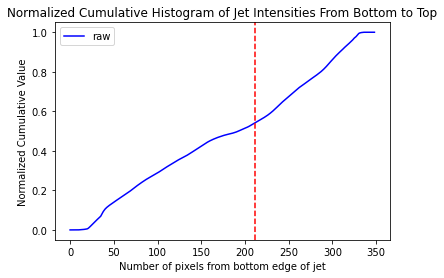


Length of Jet in Pixels: 304 pixels
Jet Length in cm (y-direction): 3.8e+23 cm
Jet Length in kpc (y-direction): 123.1496 kpc
____________________________________________________________________________________________________

File Number 7/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_0640_nu=395.0_los=0.00_1.00_0.00_64.0Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 64.0 Myr - 395 MHz
Time index: 6.4000e+01 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 1168x1168 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



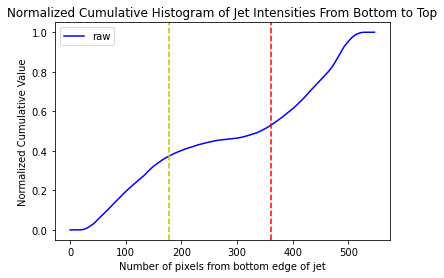


Length of Jet in Pixels: 473 pixels
Jet Length in cm (y-direction): 5.9125e+23 cm
Jet Length in kpc (y-direction): 191.6111 kpc
____________________________________________________________________________________________________

File Number 8/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_1212_nu=395.0_los=0.00_1.00_0.00_121.2Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 121.2 Myr - 395 MHz
Time index: 1.2120e+02 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 2032x2032 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



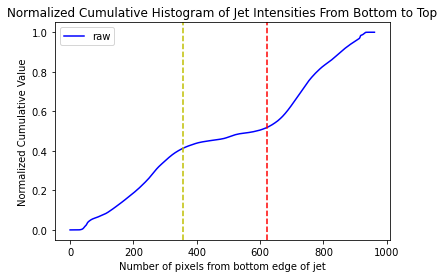


Length of Jet in Pixels: 868 pixels
Jet Length in cm (y-direction): 1.085e+24 cm
Jet Length in kpc (y-direction): 351.6246 kpc
____________________________________________________________________________________________________

File Number 9/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_2570_nu=395.0_los=0.00_1.00_0.00_256.1Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 256.1 Myr - 395 MHz
Time index: 2.5611e+02 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 4432x4432 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



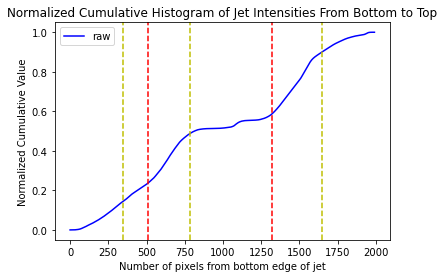


Length of Jet in Pixels: 1752 pixels
Jet Length in cm (y-direction): 2.19e+24 cm
Jet Length in kpc (y-direction): 709.7307 kpc


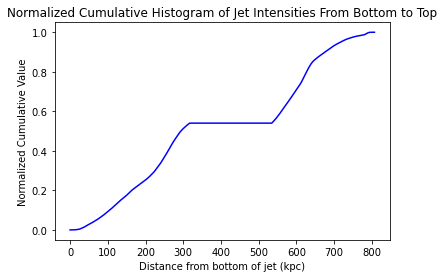


Length of Jet in Pixels: 1769 pixels
Jet Length in cm (y-direction): 2.21125e+24 cm
Jet Length in kpc (y-direction): 716.6173 kpc
Distance between lobes (inner edge to edge): 217.5373 kpc
____________________________________________________________________________________________________

File Number 10/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_5140_nu=395.0_los=0.00_1.00_0.00_513.1Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 513.1 Myr - 395 MHz
Time index: 5.1314e+02 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 6160x6160 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



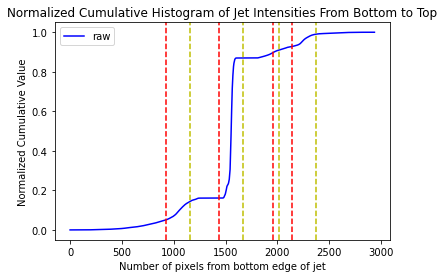


Length of Jet in Pixels: 1617 pixels
Jet Length in cm (y-direction): 2.02125e+24 cm
Jet Length in kpc (y-direction): 655.0425 kpc


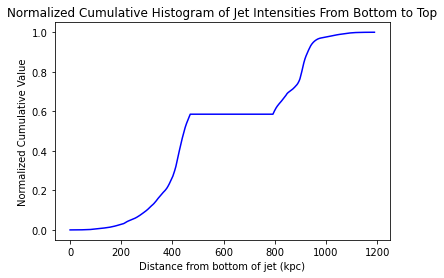


Length of Jet in Pixels: 2071 pixels
Jet Length in cm (y-direction): 2.58875e+24 cm
Jet Length in kpc (y-direction): 838.9567 kpc
Distance between lobes (inner edge to edge): 322.8626 kpc
____________________________________________________________________________________________________

File Number 11/11

File Name: Jet Simulation Data/Group_L446_rc30_beta07/fits/nu=395.0MHz/Group_L446_rc30_beta07_7740_nu=395.0_los=0.00_1.00_0.00_773.1Myr.fits.gz
Simulation Title: Simulation Group_L446_rc30_beta07 - 773.1 Myr - 395 MHz
Time index: 7.7312e+02 Myr
Pixel size: 1.2500e+21 cm
FITS Image Dimensions: 7600x7600 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



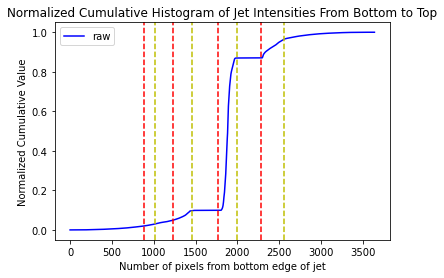


Length of Jet in Pixels: 1844 pixels
Jet Length in cm (y-direction): 2.305e+24 cm
Jet Length in kpc (y-direction): 746.9996 kpc


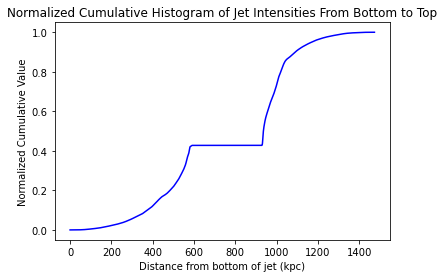


Length of Jet in Pixels: 2639 pixels
Jet Length in cm (y-direction): 3.29875e+24 cm
Jet Length in kpc (y-direction): 1069.0521 kpc
Distance between lobes (inner edge to edge): 335.8258 kpc
____________________________________________________________________________________________________



In [5]:
#Main Calling Block of Code

print("\nJET LENGTH AND WIDTH DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

path = '**/Group_L446_rc30_*nu=395.0*0.00_1.00_0.00*Myr.fits*'

# Determines if there are any files in device
total_files = len(glob.glob(path, recursive=True))

if total_files > 0:
    file_count = 0
    for file in sorted(glob.glob(path, recursive=True)):

        file_count += 1

        try:
            print("File Number {}/{}\n".format(file_count, total_files))
            print("File Name: {}".format(file))
            fits_image_hdul = fits.open(file)

            #Displays FITS Image title, time index, and pixel size
            sim_title = fits_image_hdul[0].header['OBJECT']
            sim_time = fits_image_hdul[0].header['TIME']
            pixel = fits_image_hdul[0].header['CDELT1']
            print("Simulation Title: {}".format(sim_title))
            print("Time index: {}".format(sim_time))
            print("Pixel size: {}".format(pixel))
            pixel_size = float(pixel[:-3])

            #Difines Data From FITS image and records image dimensions
            data =  fits_image_hdul[0].data
            length = len(data[0])
            width = len(data)
            print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))

            #Calls jet_length function
            print("\nJET LENGTH DATA:")
            print("{}\n".format("~"*50))
            jet_length(data, width, pixel_size)

            #Calls jet_width function
            #print("\nJET WIDTH DATA:")
            #print("{}\n".format("~"*50))
            #jet_width(data, width, pixel_size)

            print("{}\n".format("_"*100))

        except OSError:
            print("Error with file: {}".format(file))
            print("Empty or corrupt FITS file")
            
else:
    print("ERROR: Could not find any necessary files on your device")
    print("Program intakes files of the name: {}".format(path))